# Finding Correlations in High Dimensional Data

Assuming our data is generated from a high-dimensional gaussian with unknown covariance matrix we would like to infer the full posterior distribution over the entire matrix given some data.

In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import pystan

In [2]:
N     = 20                  # number of data points
K     = 10                  # number of dimensions
mu    = np.zeros(K)         # mean for generated data
tau   = np.diag(np.ones(K)) # variance for generated data
Omega = np.identity(K)      # correlation matrix for generated data

# Create some correlations
Omega[0,1] = 0.8
Omega[2,3] = 0.7
Omega[2,9] = 0.6

# Make omega symmetric
Omega = Omega + np.tril(Omega.T, -1)

# Multiply the columns and rows of the correlation matrix
# by variances to get a covariance matrix
Sigma = tau.dot(Omega).dot(tau)

data = np.random.multivariate_normal(mu, Sigma, size=N)

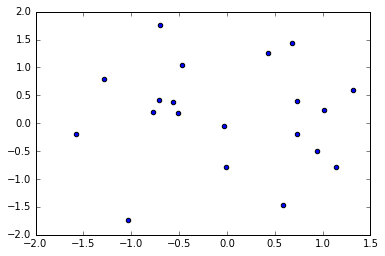

In [3]:
plt.scatter(data[:,0], data[:,4]);

In [4]:
model_code = """
data {
    int<lower=1> N;
    int<lower=2> K;
    real eta;
    
    vector[K] X[N];
}

parameters {
    vector[K] mu;
    vector<lower=0>[K] tau;
    cholesky_factor_corr[K] L_Omega;
}

model {
    matrix[K,K] L_Sigma;
    L_Sigma <- diag_pre_multiply(tau, L_Omega);    

    mu ~ cauchy(0,1);
    tau ~ cauchy(0,1);
    L_Omega ~ lkj_corr_cholesky(eta);

    X ~ multi_normal_cholesky(mu, L_Sigma);
}

/*
generated quantities {
    matrix[K,K] Omega;    
    Omega <- L_Omega * L_Omega';
    
    matrix[K,K] Sigma;
    Sigma <- diag_pre_multiply(tau, L_Omega) * diag_pre_multiply(tau, L_Omega)';
}
*/
"""
model = pystan.StanModel(model_code=model_code)

In [5]:
fit = model.sampling(data=dict(N=N, K=K, eta=2, X=data))

In [6]:
print fit

Inference for Stan model: anon_model_f4c68e80c53f3d15a92e903208be179f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]         -0.01  6.0e-3    0.2  -0.42  -0.14  -0.01   0.12    0.4 1155.0    1.0
mu[1]          0.16  5.6e-3   0.19  -0.21   0.03   0.16   0.29   0.55 1180.0    1.0
mu[2]         -0.01  6.8e-3   0.23  -0.48  -0.17  -0.01   0.13   0.45 1137.0    1.0
mu[3]          0.26  6.3e-3   0.22  -0.18   0.11   0.26   0.41    0.7 1243.0    1.0
mu[4]          0.13  6.8e-3   0.23  -0.32  -0.01   0.13   0.28   0.59 1137.0    1.0
mu[5]         -0.04  6.2e-3   0.22  -0.47  -0.18  -0.04    0.1   0.41 1211.0    1.0
mu[6]         -0.11  7.9e-3   0.27  -0.66  -0.28   -0.1   0.06   0.41 1155.0    1.0
mu[7]        8.6e-3  6.8e-3   0.24  -0.47  -0.14   0.01   0.16   0.48 1221.0    1.0
mu[8]         -0.05  6.4e-3   0.21  -0.48  -0.18  -0.04

In [7]:
samples = fit.extract()
L_Omega_samples = samples['L_Omega']
Omega_samples = np.matmul(L_Omega_samples, L_Omega_samples.transpose(0,2,1))

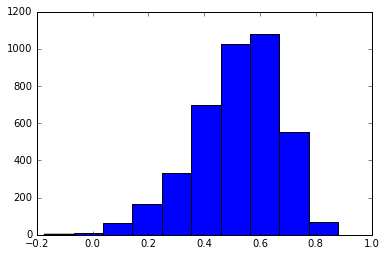

In [8]:
plt.hist(Omega_samples[:,0,1]);

In [9]:
Omega_mean = np.mean(Omega_samples, axis=0)
Omega_low  = np.percentile(Omega_samples, 2.5, axis=0)
Omega_med  = np.percentile(Omega_samples, 50, axis=0)
Omega_high = np.percentile(Omega_samples, 97.5, axis=0)

for j in range(K):
    for i in range(j):
        low  = Omega_low[i, j]
        med  = Omega_med[i, j]
        high = Omega_high[i, j]
        if low > 0:
            print "({}, {}): {:.2f} - {:.2f} - {:.2f}".format(i, j, low, med, high)

(0, 1): 0.17 - 0.54 - 0.76
(2, 3): 0.28 - 0.59 - 0.79
(7, 8): 0.01 - 0.38 - 0.67
(2, 9): 0.24 - 0.54 - 0.75


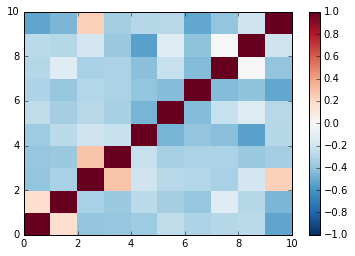

In [10]:
plt.pcolormesh(Omega_low, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar();